# Copenhagen_Networks_Study_Notebook

[paper link](https://www.nature.com/articles/s41597-019-0325-x)

[data source](https://figshare.com/articles/dataset/The_Copenhagen_Networks_Study_interaction_data/7267433/1?file=13389320)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
%matplotlib inline
from scipy import optimize

In [2]:
DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
    '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
    return pd.read_csv(os.path.join(data_dir, data_filename))  

In [4]:
# dataframe creation

df_bt = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)
# data cleaning: removing positive signal intensities
df_bt = df_bt[df_bt["rssi"] <= 0]
# data cleaning: removing contacts with non-partecipants
df_bt = df_bt[df_bt["user_b"] != -2]
# inserting column for strong/weak contacts
df_bt["weight"] = (df_bt["rssi"] >= -80) & (df_bt["rssi"] != 0)
print("bluetooth\n", df_bt.head())

df_calls = LoadData(DATA_FILENAMES["calls"], DATA_DIR)
print("\ncalls\n", df_calls.head())

df_sms = LoadData(DATA_FILENAMES["sms"], DATA_DIR)
print("\nsms\n", df_sms.head())

df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
# data cleaning: removing self-friendships
df_facebook_friends = df_facebook_friends[df_facebook_friends["user_b"] != df_facebook_friends["# user_a"]]
print("\nfacebook friends\n", df_facebook_friends.head())

df_genders = LoadData(DATA_FILENAMES["genders"], DATA_DIR)
print("\ngenders\n", df_genders.head())

bluetooth
    # timestamp  user_a  user_b  rssi  weight
0            0       0      -1     0   False
1            0       1      -1     0   False
2            0       2      -1     0   False
4            0       5      -1     0   False
5            0       6      -1     0   False

calls
    timestamp  caller  callee  duration
0        184     300     301       121
1       3920     512     299       670
2       5623     301     300       504
3       9252     401     457        -1
4      15466     512       0         5

sms
    timestamp  sender  recipient
0         18     370        512
1         37     512        370
2        126     370        512
3        134       0        512
4        312     137        136

facebook friends
    # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543

genders
    # user  female
0       0       0
1       2       0
2       3       0
3       4       0
4       5       0


# bluetooth data

In [6]:
def aggregate_strong_connections(dataframe, hrs):
    df = dataframe.loc[dataframe["weight"]].copy()
    df.drop(columns="rssi", inplace=True)
    df["# timestamp"] = df["# timestamp"] // (60*60*hrs) * (60*60*hrs)
    df = df.groupby(["# timestamp","user_a","user_b"]).sum() / (60*60*hrs/5/60)
    df.reset_index(inplace=True)
    return df

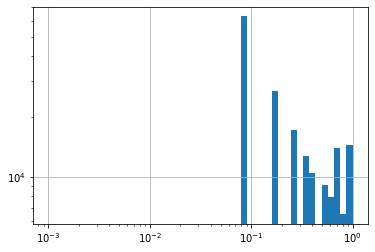

In [63]:
ax = aggregate_strong_connections(df_bt, 1)["weight"].hist(bins=np.logspace(-3,0,50))
ax.set_xscale("log")
ax.set_yscale("log")

In [5]:
def create_time_graphs(dataframe):
    times = dataframe["# timestamp"].unique()
    graphs = [nx.from_pandas_edgelist(group, source="user_a", target="user_b", edge_attr="weight") for t,group in dataframe.groupby("# timestamp")]
    return graphs

In [130]:
create_time_graphs(aggregate_strong_connections(df_bt, 6))

In [7]:
def VisualizeBluetoothNetwork(G): 
    connected_components = [G.subgraph(c) for c in nx.connected_components(G)]
    fig, axs = plt.subplots(1, len(connected_components), figsize=(60, 3), squeeze=False)
    axs = axs.flatten()
    [
      nx.draw(
          connected_component,
          # Positions of nodes are calculatued using spring layout.
          pos=nx.spring_layout(connected_component, scale=0.2),
          ax=axs[i],
          # Width of the edges is based on higher RSSI = stronger edge.
          width=[(connected_component[u][v]["weight"]*10) for u,v in connected_component.edges()],
          node_size=500,
          node_color="black",
          with_labels=True,
          font_size=10,
          font_color="white")
      for i, connected_component in enumerate(connected_components)
    ]

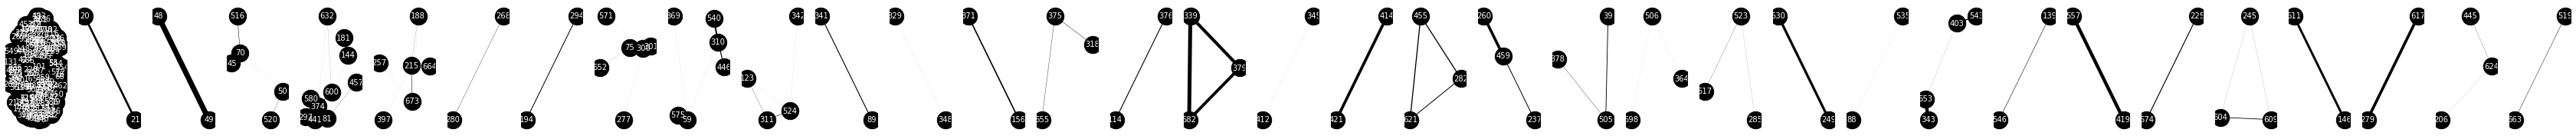

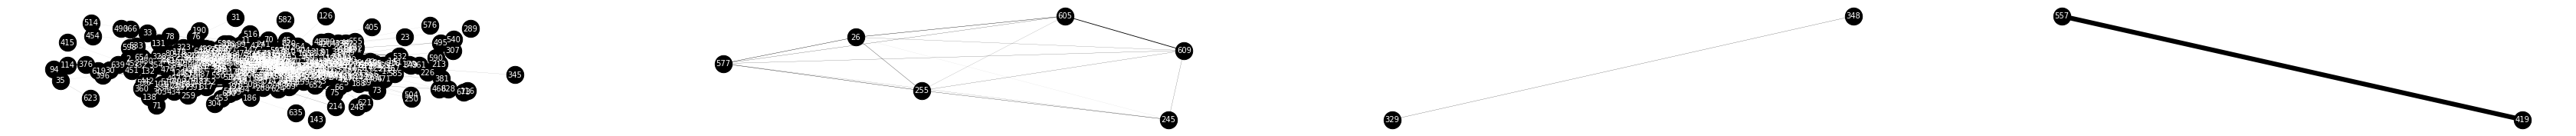

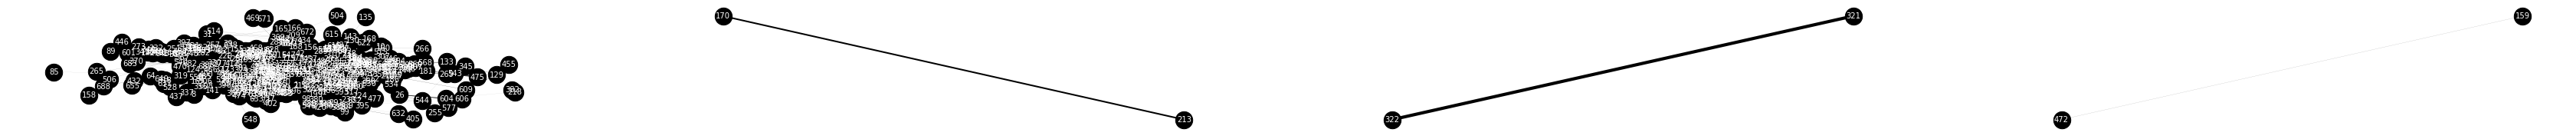

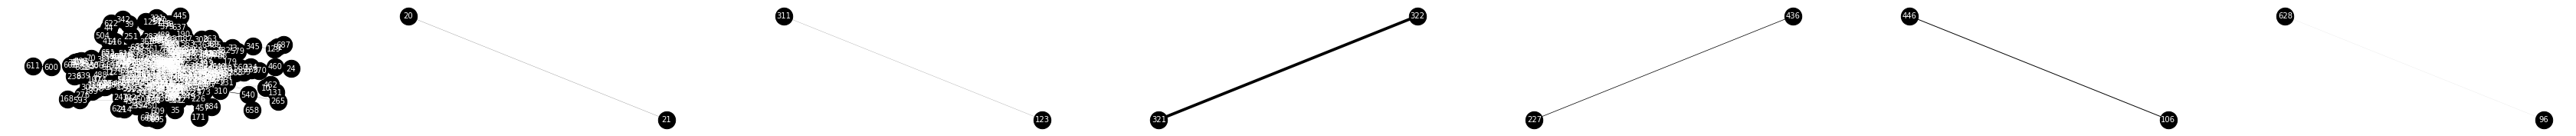

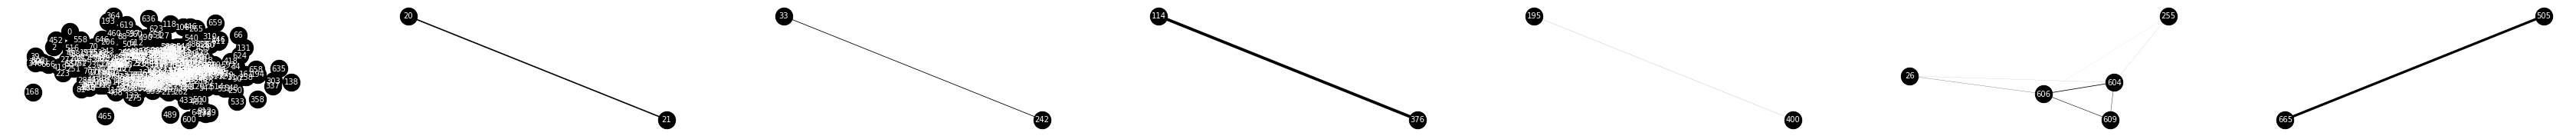

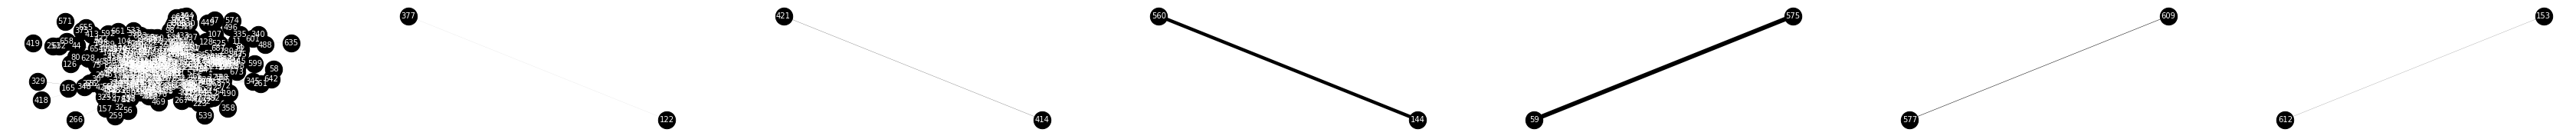

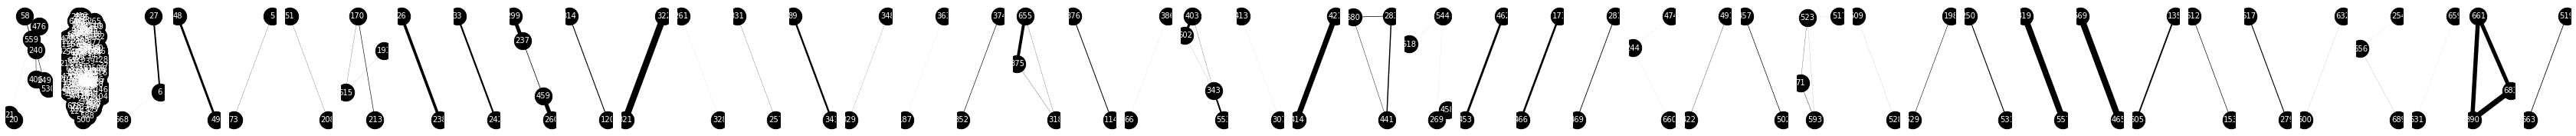

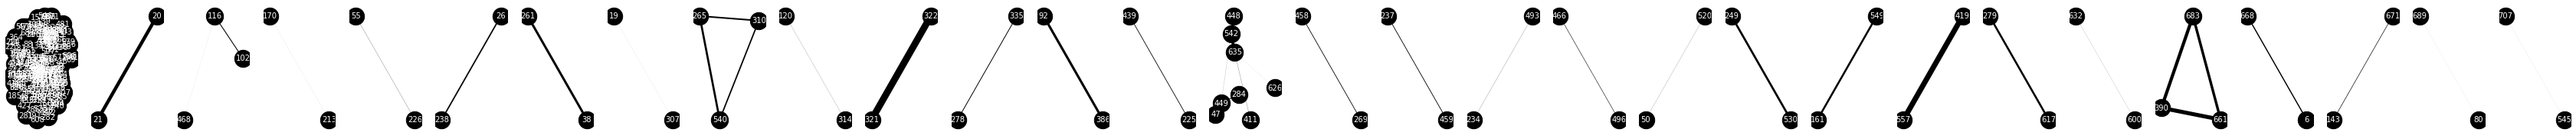

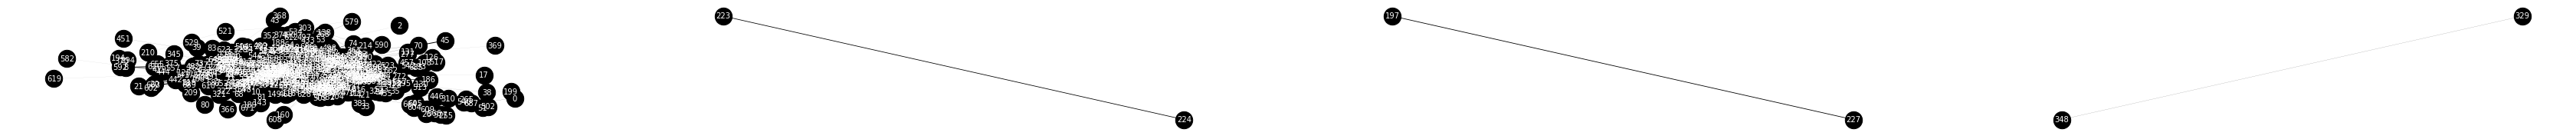

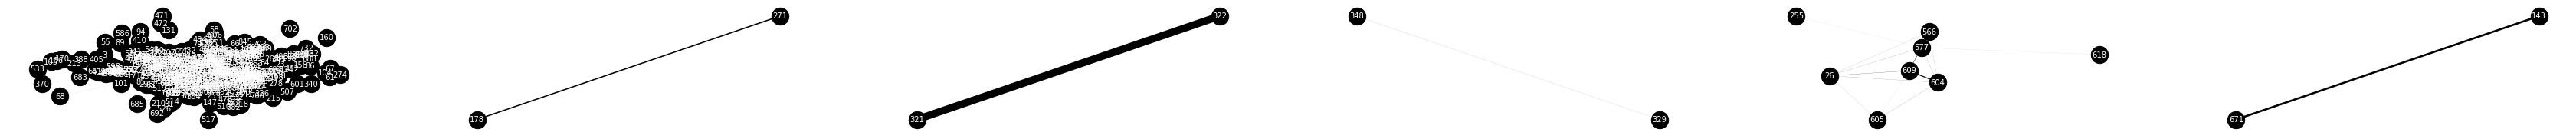

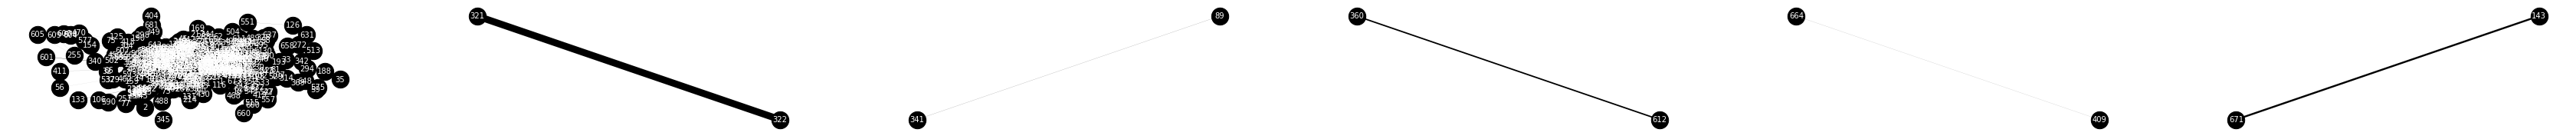

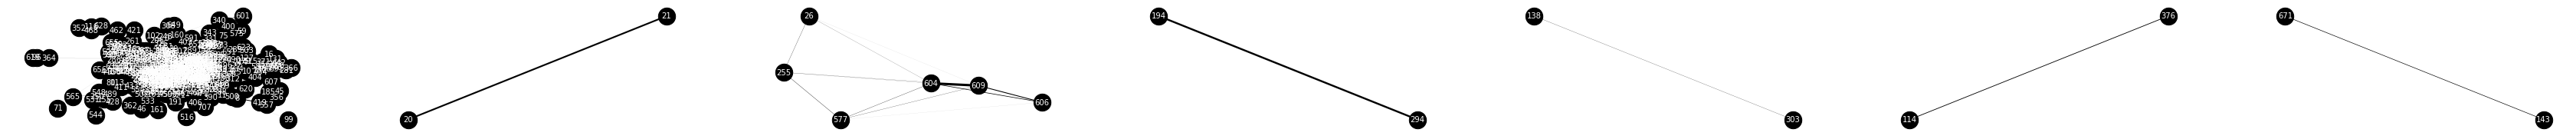

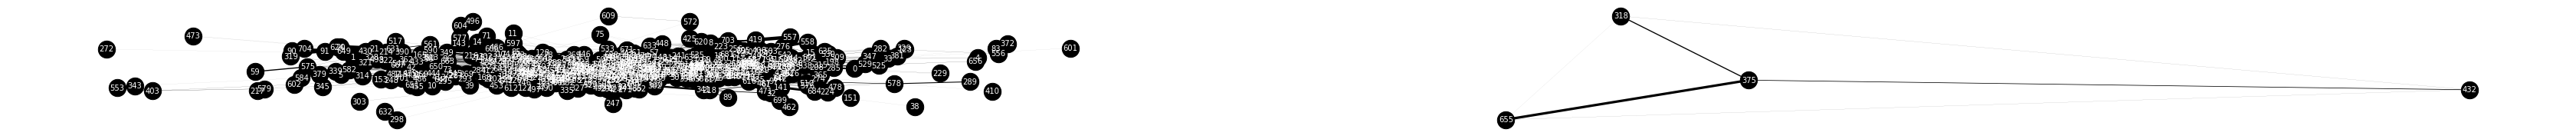

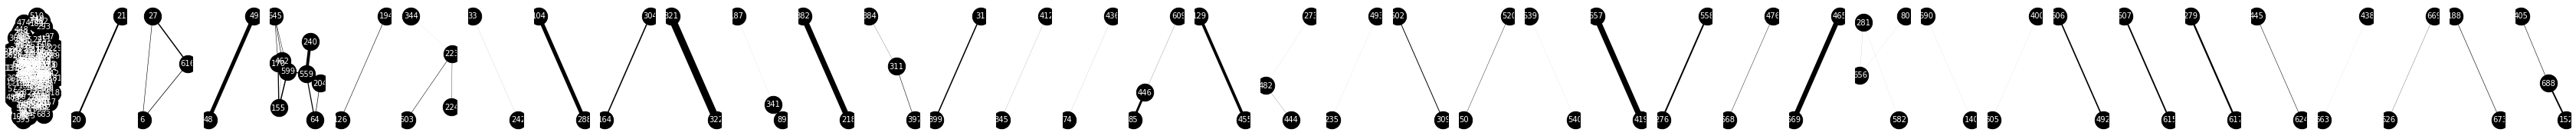

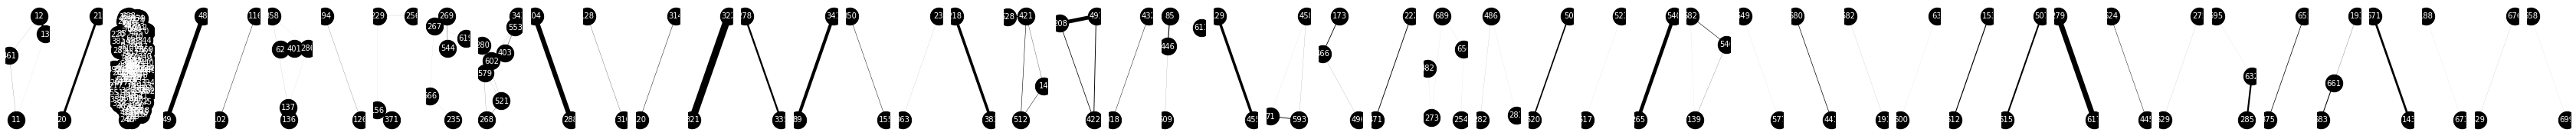

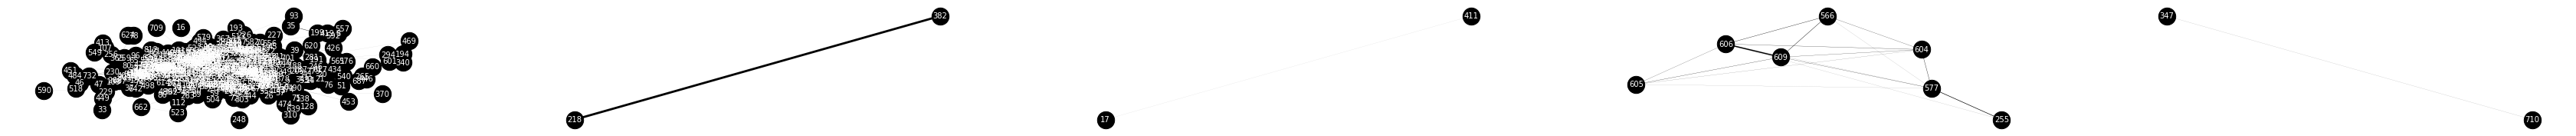

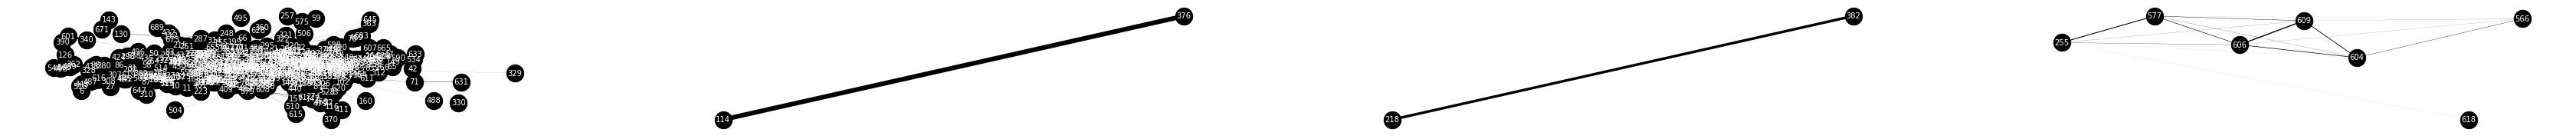

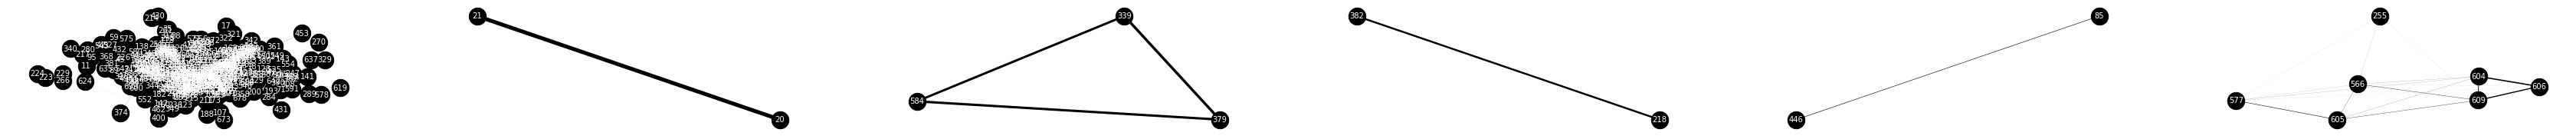

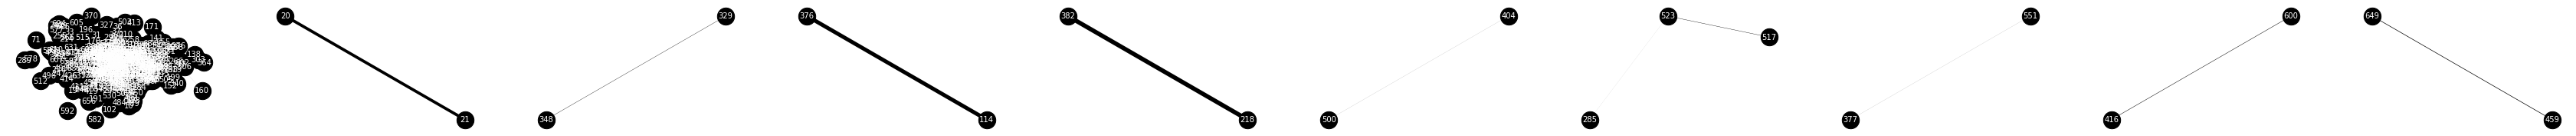

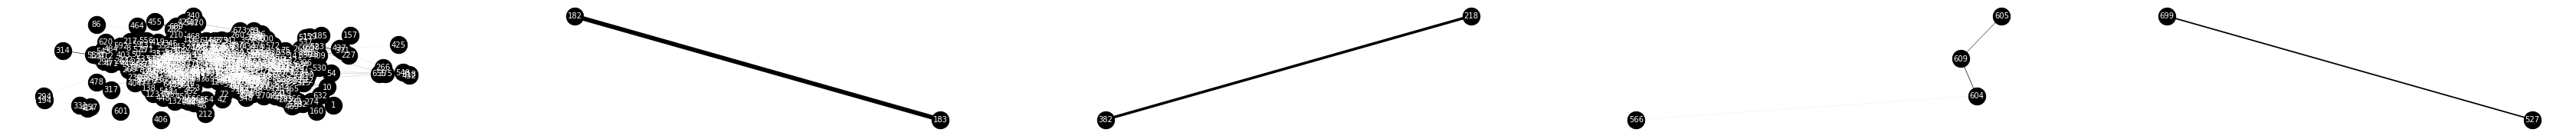

In [145]:
bt_24hr = aggregate_strong_connections(df_bt, 24)
graphs = create_time_graphs(bt_24hr)
for i,G in enumerate(graphs):
    VisualizeBluetoothNetwork(G)
    if i == 19:
        break

### idee

- plottare la degree distribution dei vari nodi al variare dei giorni della settimana. E confrontare diversi plot su settimane diverse.

- studiare la variazione, in funzione della discretizzazione temporale (ore/giorni/...), la dimensione dei cluster più grande, e del numero di cluster.

- controllare se i cluster ottenuti nelle 6 ore notturne sono composti dagli stessi nodi dei cluster orari nelle ore notturne, anche al variare dei giorni

- per ogni nodo il degree medio giornaliero (come misura della "socialità"), e plottare la distribuzione al variare dei nodi di questo degree medio

### Largest cluster for different discretizations

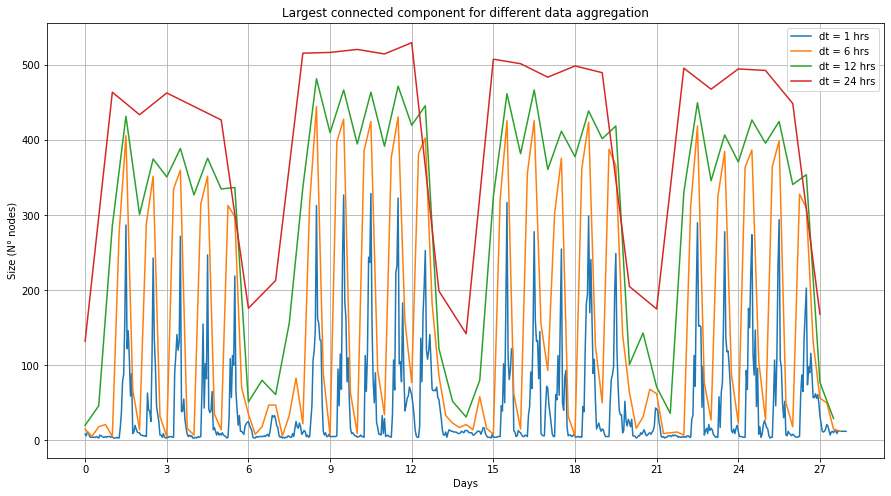

In [179]:
plt.figure(figsize=(15,8))
for dt in [1, 6, 12, 24]:
    df = aggregate_strong_connections(df_bt, dt)
    graphs = create_time_graphs(df)
    nodes_largest_cluster = [max([len(G.subgraph(c)) for c in nx.connected_components(G)]) for G in graphs]
    plt.plot(np.arange(len(graphs))*dt/24, nodes_largest_cluster, label=f"dt = {dt} hrs")
    plt.title("Largest connected component for different data aggregation")
    plt.ylabel("Size (N° nodes)")
    plt.xlabel("Days")
    plt.xticks(np.linspace(0,27,10))
    plt.grid(True)
    plt.legend()

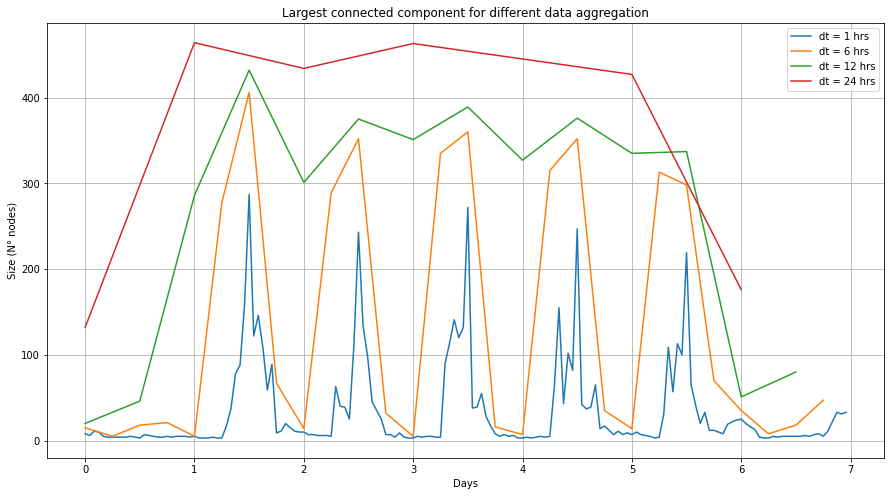

In [170]:
plt.figure(figsize=(15,8))
for dt in [1, 6, 12, 24]:
    df = aggregate_strong_connections(df_bt[df_bt["# timestamp"] < 60*60*24*7], dt)
    graphs = create_time_graphs(df)
    nodes_largest_cluster = [max([len(G.subgraph(c)) for c in nx.connected_components(G)]) for G in graphs]
    plt.plot(np.arange(len(graphs))*dt/24, nodes_largest_cluster, label=f"dt = {dt} hrs")
    plt.title("Largest connected component for different data aggregation")
    plt.ylabel("Size (N° nodes)")
    plt.xlabel("Days")
    plt.xticks(np.linspace(0,7,8))
    plt.grid(True)
    plt.legend()

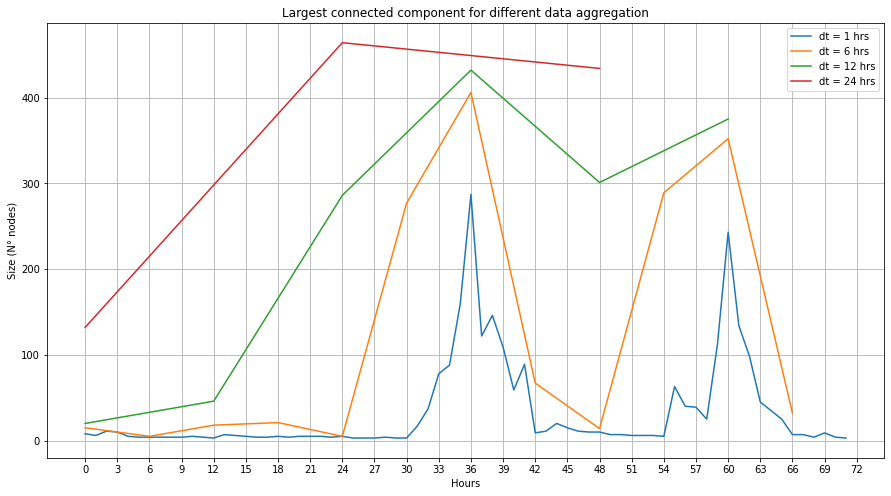

In [11]:
plt.figure(figsize=(15,8))
for dt in [1, 6, 12, 24]:
    df = aggregate_strong_connections(df_bt[df_bt["# timestamp"] < 60*60*24*3], dt)
    graphs = create_time_graphs(df)
    nodes_largest_cluster = [max([len(G.subgraph(c)) for c in nx.connected_components(G)]) for G in graphs]
    plt.plot(np.arange(len(graphs))*dt, nodes_largest_cluster, label=f"dt = {dt} hrs")
    plt.title("Largest connected component for different data aggregation")
    plt.ylabel("Size (N° nodes)")
    plt.xlabel("Hours")
    plt.xticks(np.linspace(0,72,25))
    plt.grid(True)
    plt.legend()

## Sociality distribution of nodes

The sociality is measured as the average daily rate of interactions of a node with the others in the experiment. The sociality distribution is then plotted to check if there are few popular nodes.

In [15]:
bt_24hr = aggregate_strong_connections(df_bt, 24)
graphs = create_time_graphs(bt_24hr)

[ 12  48  52  92 100 149 208 235 243 373 386 401 491 553 560 682 688]


<AxesSubplot:>

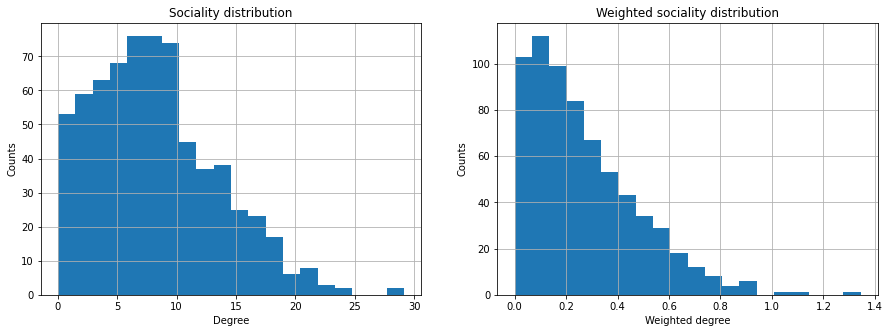

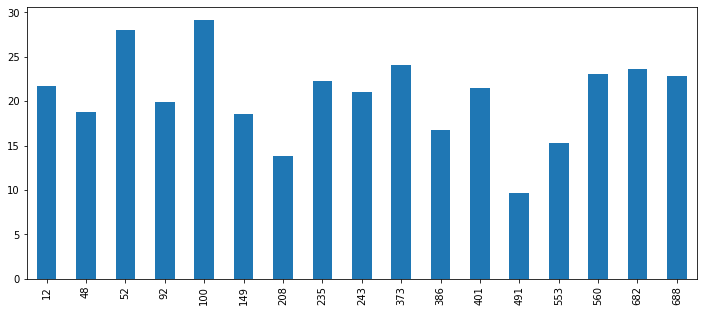

In [138]:
# sociality = number of contacts
list_of_df = [pd.DataFrame.from_dict(dict(graphs[i].degree()), orient="index") for i in range(28)]
df = pd.concat(list_of_df, axis="columns", ignore_index=True).fillna(0)
mean_dailysociality = df.mean(axis=1)
# sociality = weighted number of contacts
list_of_df = [pd.DataFrame.from_dict(dict(graphs[i].degree(weight="weight")), orient="index") for i in range(28)]
df = pd.concat(list_of_df, axis="columns", ignore_index=True).fillna(0)
mean_weighteddailysociality = df.mean(axis=1)
# plot sociality distribution
fig, axs = plt.subplots(1, 2, figsize=(15,5))
mean_dailysociality.hist(bins=20, ax=axs[0])
axs[0].set_title("Sociality distribution")
axs[0].set_xlabel("Degree")
mean_weighteddailysociality.hist(bins=20, ax=axs[1])
axs[1].set_title("Weighted sociality distribution")
axs[1].set_xlabel("Weighted degree")
for ax in axs:
    ax.set_ylabel("Counts")
# comparison between top 10 scorer in both distributions
top_scorers = np.unique(
    np.append(
        mean_dailysociality.sort_values().index[-10::],
        mean_weighteddailysociality.sort_values().index[-10::]
    )
)
print(top_scorers)
fig, ax = plt.subplots(figsize=(12,5))
mean_dailysociality[top_scorers].plot(kind="bar", ax=ax)
mean_weighteddailysociality[top_scorers].plot(kind="bar", ax=ax)

[ 12  48  52  92 100 149 208 235 243 373 386 401 491 553 560 682 688]


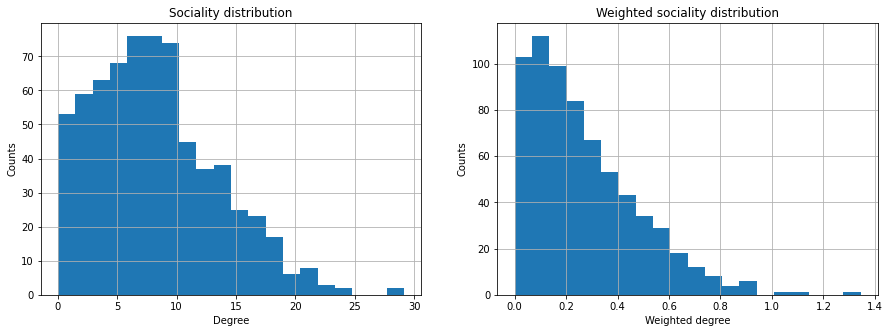

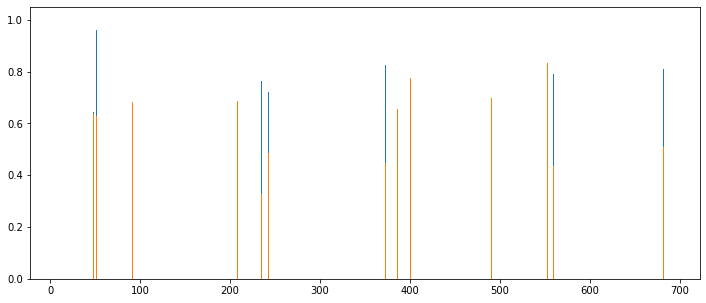

In [142]:
# sociality = number of contacts
list_of_df = [pd.DataFrame.from_dict(dict(graphs[i].degree()), orient="index") for i in range(28)]
df = pd.concat(list_of_df, axis="columns", ignore_index=True).fillna(0)
mean_dailysociality = df.mean(axis=1)
# sociality = weighted number of contacts
list_of_df = [pd.DataFrame.from_dict(dict(graphs[i].degree(weight="weight")), orient="index") for i in range(28)]
df = pd.concat(list_of_df, axis="columns", ignore_index=True).fillna(0)
mean_weighteddailysociality = df.mean(axis=1)
# plot sociality distribution
fig, axs = plt.subplots(1, 2, figsize=(15,5))
mean_dailysociality.hist(bins=20, ax=axs[0])
axs[0].set_title("Sociality distribution")
axs[0].set_xlabel("Degree")
mean_weighteddailysociality.hist(bins=20, ax=axs[1])
axs[1].set_title("Weighted sociality distribution")
axs[1].set_xlabel("Weighted degree")
for ax in axs:
    ax.set_ylabel("Counts")
# comparison between top 10 scorer in both distributions
top_scorers = np.unique(
    np.append(
        mean_dailysociality.sort_values().index[-10::],
        mean_weighteddailysociality.sort_values().index[-10::]
    )
)
print(top_scorers)
fig, ax = plt.subplots(figsize=(12,5))
for arr in [mean_dailysociality, mean_weighteddailysociality]:
    ax.bar(top_scorers, arr[top_scorers]/max(arr[top_scorers]))

<AxesSubplot:>

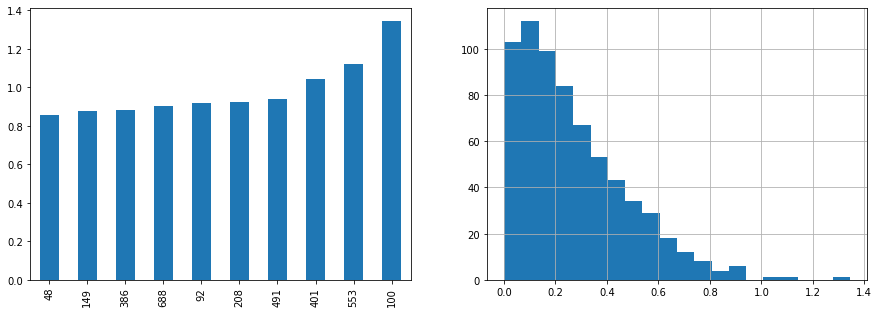

In [125]:
list_of_df = [pd.DataFrame.from_dict(dict(graphs[i].degree(weight="weight")), orient="index") for i in range(28)]
df = pd.concat(list_of_df, axis="columns", ignore_index=True).fillna(0)
mean_dailysociality = df.mean(axis=1)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
istogramma = mean_dailysociality.hist(bins=20, ax=axs[1])
mean_dailysociality.sort_values()[-10::].plot(kind="bar", ax=axs[0])

In [123]:
np.histogram(mean_dailysociality, bins=20)

(array([103, 112,  99,  84,  67,  53,  43,  34,  29,  18,  12,   8,   4,
          6,   0,   1,   1,   0,   0,   1]),
 array([1.24007937e-04, 6.73301091e-02, 1.34536210e-01, 2.01742312e-01,
        2.68948413e-01, 3.36154514e-01, 4.03360615e-01, 4.70566716e-01,
        5.37772817e-01, 6.04978919e-01, 6.72185020e-01, 7.39391121e-01,
        8.06597222e-01, 8.73803323e-01, 9.41009425e-01, 1.00821553e+00,
        1.07542163e+00, 1.14262773e+00, 1.20983383e+00, 1.27703993e+00,
        1.34424603e+00]))

# SMS data

In [16]:
df_sms

,timestamp,sender,recipient
0,18,370,512
1,37,512,370
2,126,370,512
3,134,0,512
4,312,137,136
...,...,...,...
24328,2415198,238,26
24329,2416413,137,136
24330,2417238,136,137
24331,2417633,323,392


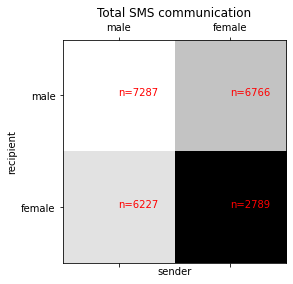

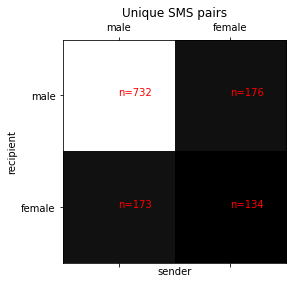

In [17]:
def VisualizeTextMessages(df_sms, df_genders):
    """Plots the SMS communication by gender of senders and recipients."""

    # Creates SMS network including gender of the senders.
    df_sms_with_gender_sender = pd.merge(
      df_sms, df_genders, left_on="sender", right_on="# user").rename(
          index=str, columns={
              "female": "female_sender"
          }).drop(
              "# user", axis=1)

    # Creates SMS network including gender of the recipients.
    df_sms_with_gender = pd.merge(df_sms_with_gender_sender,df_genders,left_on="recipient",right_on="# user").rename(
      index=str, columns={"female": "female_recipient"}).drop("# user", axis=1)

    # Computes total communication (all messages) and number of unique pairs based
    # on sender and recipient gender.
    totals = np.zeros((2, 2))
    unique_pairs = np.zeros((2, 2))
    for female_sender in [0, 1]:
        for female_recipient in [0, 1]:
            totals[female_sender, female_recipient] = df_sms_with_gender[
              (df_sms_with_gender["female_sender"] == female_sender)
              &
              (df_sms_with_gender["female_recipient"] == female_recipient)].shape[0]
            unique_pairs[female_sender, female_recipient] = df_sms_with_gender[
              (df_sms_with_gender["female_sender"] == female_sender)
              & (df_sms_with_gender["female_recipient"] == female_recipient)][[
                  "sender", "recipient"
              ]].drop_duplicates().shape[0]

    # Plots the breakdowns.
    plt.matshow(totals, cmap=plt.cm.gray)
    plt.grid(False)
    plt.xlabel("sender")
    plt.ylabel("recipient")
    plt.xticks([0, 1], ["male", "female"])
    plt.yticks([0, 1], ["male", "female"])
    [
      plt.text(
          sender,
          recipient,
          "n={}".format(int(totals[sender][recipient])),
          color="red")
      for sender, recipient in itertools.product([0, 1], [0, 1])
    ]
    plt.title("Total SMS communication")

    plt.matshow(unique_pairs, cmap=plt.cm.gray)
    plt.grid(False)
    plt.xlabel("sender")
    plt.ylabel("recipient")
    plt.xticks([0, 1], ["male", "female"])
    plt.yticks([0, 1], ["male", "female"])
    [
      plt.text(
          sender,
          recipient,
          "n={}".format(int(unique_pairs[sender][recipient])),
          color="red")
      for sender, recipient in itertools.product([0, 1], [0, 1])
    ]
    plt.title("Unique SMS pairs")


VisualizeTextMessages(df_sms, df_genders)

# calls data

In [18]:
df_calls

,timestamp,caller,callee,duration
0,184,300,301,121
1,3920,512,299,670
2,5623,301,300,504
3,9252,401,457,-1
4,15466,512,0,5
...,...,...,...,...
3595,2414934,706,401,78
3596,2415585,218,382,48
3597,2416059,561,631,13
3598,2416368,323,392,4


<AxesSubplot:>

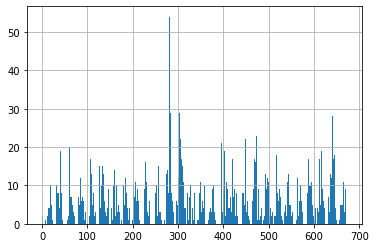

In [19]:
(df_calls["timestamp"] / 60/60).hist(bins=28*24)

# facebook data

In [20]:
df_facebook_friends

,# user_a,user_b
0,0,512
1,0,263
2,0,525
3,0,285
4,0,543
...,...,...
6424,510,737
6425,510,763
6426,255,566
6427,255,605


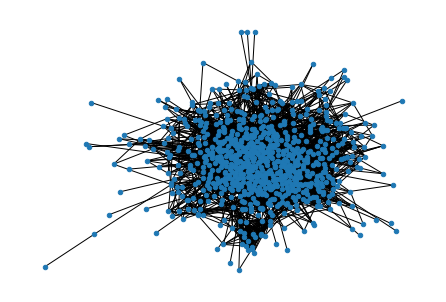

In [21]:
# create the graph
Gfacebook = nx.from_pandas_edgelist(df_facebook_friends, source="# user_a", target="user_b")

nx.draw(Gfacebook, node_size=20)

##### degree distribution

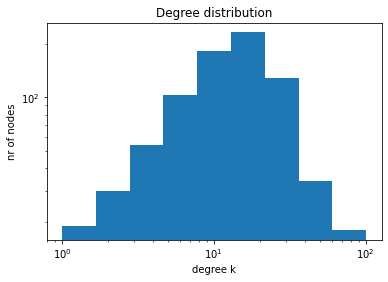

In [43]:
# degree distribution

degree_sequence = np.array(sorted((d for n, d in Gfacebook.degree()), reverse=True))
bin_edges = np.logspace(np.log10(degree_sequence.min()), np.log10(degree_sequence.max()), 10)
plt.hist(degree_sequence,bins=bin_edges)

plt.xscale('log')
plt.yscale('log')
plt.title('Degree distribution')
plt.xlabel('degree k')
plt.ylabel('nr of nodes')
plt.show()

La degree distribution è Poissoniana visto che non ha andamento di power law (non è lineare in log log)?\
Oppure abbiamo solo sbagliato il binning?

Complementary Cumulative Degree Distribution

When plotting the complementary cumulative degree distribution, $P_k \sim k^{ -(\gamma-1)}$ \
$\to$ linear fit $(y=mx+q)$ where $\gamma=1-m$

gamma = 1.0


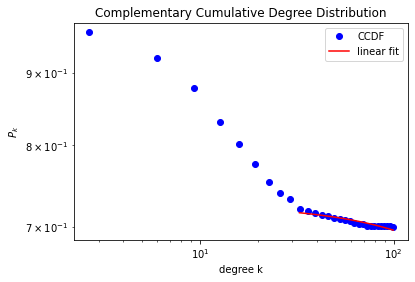

In [23]:
# CCDF
points, edg = np.histogram(degree_sequence,bins=30,density=True)

x = (edg[1:]+edg[:-1])*0.5
y = 1-np.cumsum(points)

# linear fit
def f(X,m,q):
    return X*m+q

popt, pcov = optimize.curve_fit(f,x[9:],y[9:])
gamma = 1-popt[0] 
print('gamma =',np.round(gamma,2))

# plot
plt.plot(x,y,'bo',label='CCDF')
plt.plot(x[9:],f(x[9:],popt[0],popt[1]),'r-',label='linear fit')
plt.title('Complementary Cumulative Degree Distribution')
plt.xlabel('degree k')
plt.ylabel(r'$P_k$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [24]:
# network parameters

N = Gfacebook.number_of_nodes()
L = Gfacebook.number_of_edges()
k_mean = np.mean(degree_sequence)
d_mean = nx.average_shortest_path_length(Gfacebook)
d_mean_est = np.log2(N)/np.log2(k_mean)
d_max = nx.diameter(Gfacebook)
print('N=',N,' L=',L,' k_mean=',int(k_mean),' d_mean=',np.round(d_mean,2),
      ' d_mean_est=',np.round(d_mean_est,2),' d_max=',d_max)

N= 800  L= 6418  k_mean= 16  d_mean= 2.98  d_mean_est= 2.41  d_max= 7


##### Preferential attachment
ritorna score per ogni coppia, capirne il senso

In [27]:
# preferential attachment score
preds = nx.preferential_attachment(Gfacebook)

#for u, v, p in preds:
    #print(f"({u}, {v}) -> {p}")

##### Centrality
The **degree centrality** for a node v is the fraction of nodes it is connected to.\
The **eigenvector centrality** computes the centrality for a node based on the centrality of its neighbors.\
The **closeness centrality** of a node u is the reciprocal of the average shortest path distance to u over all n-1 reachable nodes.\
The **betweenness centrality** of a node v is the sum of the fraction of all-pairs shortest paths that pass through v

In [28]:
# degree centrality
DC = nx.degree_centrality(Gfacebook)

# # bar plot 
# names = list(DC.keys())
# values = list(DC.values())

# plt.figure(figsize=(20,3))
# plt.bar(range(len(DC)), values, tick_label=names)
# plt.xlim(0,800)
# plt.show()

In [29]:
# eigenvector centrality
EC = nx.eigenvector_centrality(Gfacebook)

In [30]:
# closeness centrality
CC = nx.closeness_centrality(Gfacebook)

In [32]:
# betweeness centrality
BC = nx.betweenness_centrality(Gfacebook)

##### PageRank


In [33]:
PR = nx.pagerank(Gfacebook)

##### HITS

In [34]:
HITS = nx.hits(Gfacebook)

/home/dario/.local/lib/python3.8/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


##### Clustering
The clustering of a node v is the fraction of possible triangles through that node that exist

In [35]:
clust = nx.clustering(Gfacebook)
avg_clust = nx.average_clustering(Gfacebook)

##### Community detection

[paper in cui sembra mergino diversi network es scuola, social etc](https://www.sciencedirect.com/science/article/abs/pii/S0370157309002841)